In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import altair
import seaborn
RANDOM_SEED = 511
rng = np.random.default_rng(RANDOM_SEED)
seaborn.set_theme(style="darkgrid")
altair.renderers.enable('mimetype')

db_url: str = os.getenv('DB_URL')

In [6]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from lib import wrap_labels, adjust_pairplot_axes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# OTP Overconcentration

The data below is essentially the same as the GHC website's "oversaturation data", except:
* I don't drop patient zip codes outside NYC, which I believe fell through a join somewhere


My goal is to make the "OTP programs are overconcentrated in Harlem" in a bunch of ways:
* Harlem Admission % ~ Harlem Capacity % > Harlem Patient % > Harlem population %
    * Compare with other areas of the city
* Compare fractions of admissions residing outside across different districts
    * Across programs?
* Compare with OD rates?

## By District (no patient residences, but I currently have populations)

In [8]:
sql = """
select
    borough_district_code,
    population_2020 AS "Population", 
    CASE WHEN is_harlem THEN 'Harlem' ELSE 'Rest of NYC' END AS is_harlem,
    total_admissions_3_2017 AS "Estimated OTP Admissions (2017)",
    total_admissions_3_2019 AS "Estimated OTP Admissions (2019)",
    otp_capacity AS "Reported OTP Capacity (2019)",
    avg_daily_enrollment_2019 AS "Reported Daily Avg OTP Enrollment (2019)"
from district_otp_analysis
"""
district_df = pd.read_sql(sql, con=db_url)
district_df = district_df.fillna(0)

for c in [
    'borough_district_code',
    'is_harlem'
]:
    district_df[c] = pd.Categorical(district_df[c])

district_df['Estimated Fraction of OTP Admissions (2019)'] = district_df["Estimated OTP Admissions (2019)"] \
    / district_df["Estimated OTP Admissions (2019)"].sum()
district_df['Fraction of Population'] = district_df["Population"] \
    / district_df["Population"].sum()

district_df = district_df.set_index('borough_district_code')
district_df.T[[110, 111]]


borough_district_code,110,111
Population,130440,125771
is_harlem,Harlem,Harlem
Estimated OTP Admissions (2017),435.0,1947.0
Estimated OTP Admissions (2019),592.0,1999.0
Reported OTP Capacity (2019),1400,4029
Reported Daily Avg OTP Enrollment (2019),1277.0,3584.0
Estimated Fraction of OTP Admissions (2019),0.046264,0.156221
Fraction of Population,0.014817,0.014287


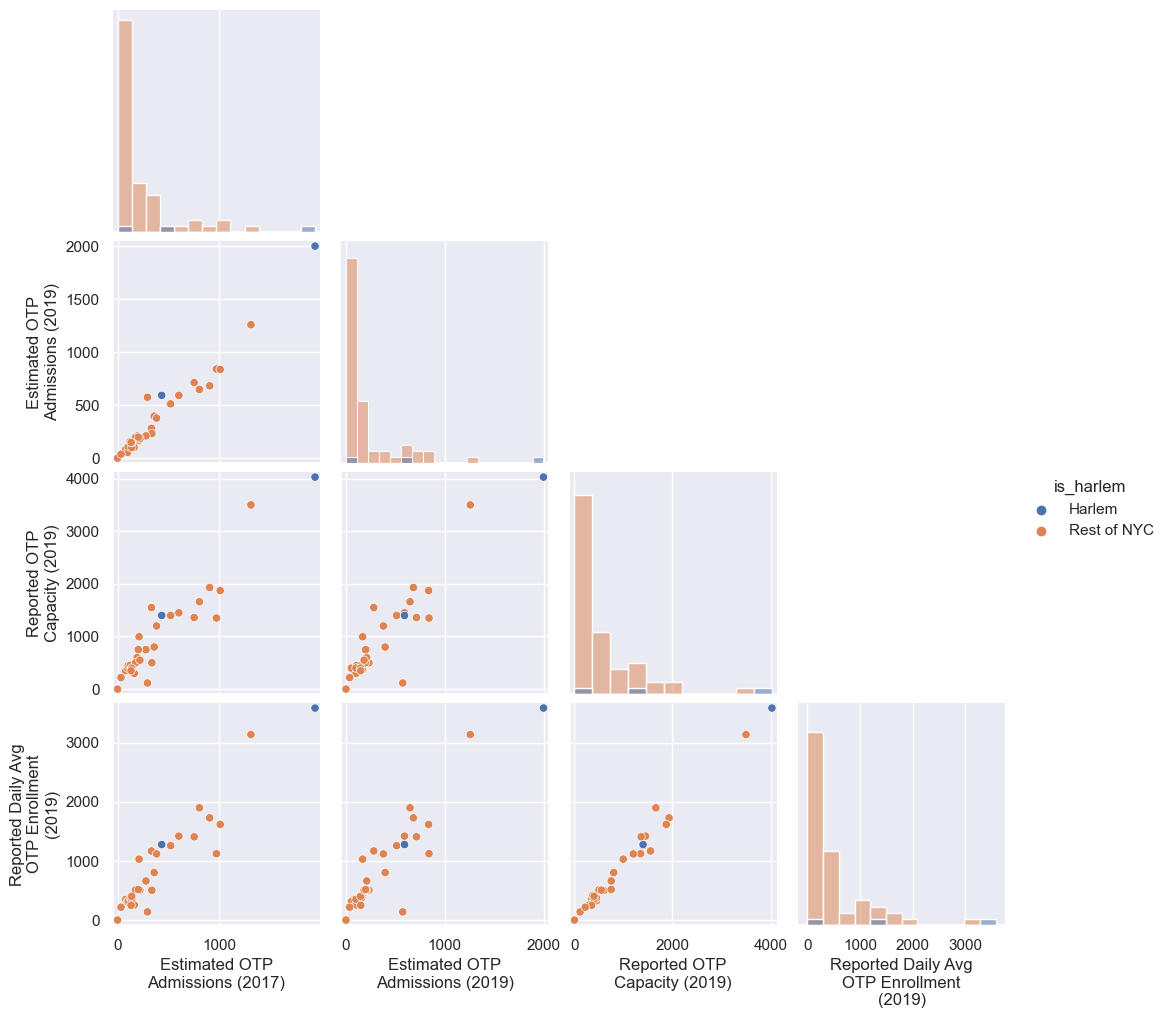

In [9]:
measures = [
    'Estimated OTP Admissions (2017)',
    'Estimated OTP Admissions (2019)',
    'Reported OTP Capacity (2019)',
    'Reported Daily Avg OTP Enrollment (2019)'
]

p = seaborn.pairplot(
    district_df[measures + ['is_harlem']], 
    hue='is_harlem',
    diag_kind="hist", 
    corner=True
);

adjust_pairplot_axes(district_df, measures, p)

,Population,Estimated OTP Admissions (2019),Reported OTP Capacity (2019),Reported Daily Avg OTP Enrollment (2019)
is_harlem,,,,
Harlem,0.041652,0.202485,0.169879,0.166718
Rest of NYC,0.958348,0.797515,0.830121,0.833282


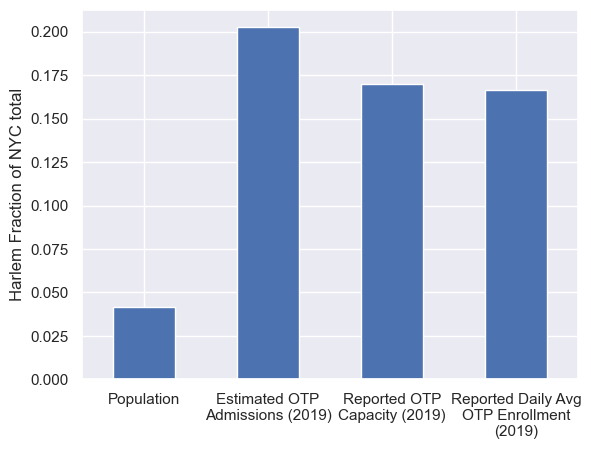

In [10]:
district_metrics_by_harlem = (
    district_df[[
        'Population',
        'Estimated OTP Admissions (2019)',
        'Reported OTP Capacity (2019)',
        'Reported Daily Avg OTP Enrollment (2019)',
    ]]
    .groupby(district_df['is_harlem'])
    .sum()
)
district_metrics_by_harlem = district_metrics_by_harlem / district_metrics_by_harlem.sum()
ax = district_metrics_by_harlem.loc['Harlem'].plot(
    kind='bar',
    ylabel='Harlem Fraction of NYC total'
);
plt.xticks(rotation=0)
wrap_labels(ax, 20)
district_metrics_by_harlem

,Population,Estimated OTP Admissions (2019),Reported OTP Capacity (2019),Reported Daily Avg OTP Enrollment (2019)
borough_district_code,,,,
111,0.014287,0.156221,0.126072,0.122921
201,0.011465,0.098312,0.109519,0.107556
206,0.010134,0.050641,0.051943,0.065096
106,0.017677,0.053298,0.060392,0.059265
103,0.018532,0.065333,0.058608,0.055458
306,0.012942,0.046264,0.045372,0.048668
205,0.015061,0.055721,0.042556,0.048290
110,0.014817,0.046264,0.043807,0.043797
102,0.010501,0.040013,0.043807,0.043146


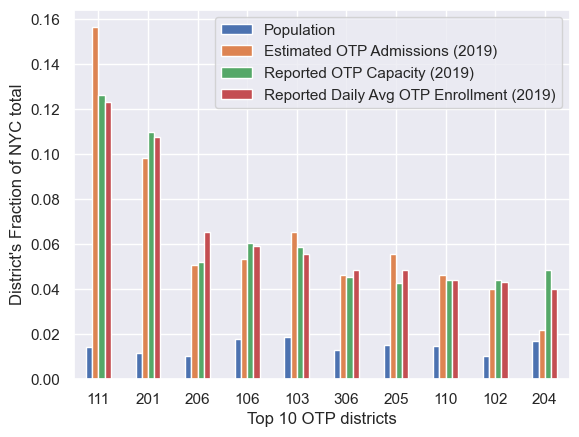

In [12]:
district_metrics_by_district = (
    district_df[[
        'Population',
        'Estimated OTP Admissions (2019)',
        'Reported OTP Capacity (2019)',
        'Reported Daily Avg OTP Enrollment (2019)',
    ]]
    .sort_values("Reported Daily Avg OTP Enrollment (2019)", ascending=False)
)
district_metrics_by_district = district_metrics_by_district.head(10) / district_metrics_by_district.sum()
district_metrics_by_district.plot(
    kind='bar',
    ylabel="District's Fraction of NYC total",
    xlabel='Top 10 OTP districts'
);
plt.xticks(rotation=0)
district_metrics_by_district